In [1]:
!date

Tue Nov 10 11:21:33 PST 2020


# Compare good vs bad GENE level quantification

In [1]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

def nd(arr):
    return np.asarray(arr).reshape(-1)

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [3]:
good = pd.read_csv("../../tables/unordered/union_test_subclass_DE.csv", index_col=0)
bad  = pd.read_csv("../../tables/unordered/union_test_subclass_DE_bad.csv", index_col=0)

In [4]:
gene_good = anndata.read_h5ad("../../data/notebook/revision/no_filter_gene.h5ad")
gene_bad  = anndata.read_h5ad("../../data/notebook/revision/bad_gene.h5ad")

In [5]:
good.groupby("index")['name'].count()

index
Astro           282
Endo            714
L2/3 IT        6435
L5 IT          5675
L5 PT          8376
L5/6 NP        4603
L6 CT          5154
L6 IT          5907
L6 IT Car3     7465
L6b            5357
Lamp5          3245
Low Quality    4059
Pvalb          3556
SMC             486
Sncg           3632
Sst            3356
VLMC            787
Vip            1928
Name: name, dtype: int64

In [6]:
bad.groupby("index")['name'].count()

index
Astro           282
Endo            714
L2/3 IT        6435
L5 IT          5675
L5 PT          8376
L5/6 NP        4603
L6 CT          5154
L6 IT          5907
L6 IT Car3     7465
L6b            5357
Lamp5          3245
Low Quality    4059
Pvalb          3556
SMC             486
Sncg           3632
Sst            3356
VLMC            787
Vip            1928
Name: name, dtype: int64

In [7]:
good.index = good["index"] + "_" + good["name"]
bad.index = bad["index"] + "_" + bad["name"]

In [8]:
alpha=0.01
bad = bad.query(f"p_corr  < {alpha}")
good = good.query(f"p_corr  < {alpha}")

In [9]:
fn = np.setdiff1d(good.index.values, bad.index.values)
fp =  np.setdiff1d(bad.index.values,good.index.values)

# False positive

In [33]:
bad.loc[fp].sort_values("p_corr").head()

,index,name,p_raw,p_corr,es
Pvalb_Nrxn1_ENSMUSG00000024109,Pvalb,Nrxn1_ENSMUSG00000024109,2.235379e-55,7.949008e-52,-0.436161
L6b_Calm3_ENSMUSG00000019370,L6b,Calm3_ENSMUSG00000019370,1.789409e-38,9.585865e-35,-0.179948
L6 IT_Smarca2_ENSMUSG00000024921,L6 IT,Smarca2_ENSMUSG00000024921,2.668749e-35,1.576430e-31,0.419614
Pvalb_Camta1_ENSMUSG00000014592,Pvalb,Camta1_ENSMUSG00000014592,1.636207e-33,5.818351e-30,0.425931
Pvalb_Rbx1_ENSMUSG00000022400,Pvalb,Rbx1_ENSMUSG00000022400,1.342631e-27,4.774395e-24,0.142357


In [86]:
specific_cluster = "Pvalb"
specific_gene = "Camta1_ENSMUSG00000014592"

In [68]:
specific_gene

'Camta1_ENSMUSG00000014592'

In [69]:
def yex(ax):
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

In [70]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    selected = kwd.get("selected", None)
    color = kwd.get("color", "grey")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
        if selected == vidx:
            v.set_facecolor("#D43F3A")

            
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 5, color="white", edgecolor="black", linewidth=1)
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean, color="lightgrey", edgecolor="black", linewidth=1, zorder=10)    
        ax.vlines(x, mean - stdev, mean+stdev, color='lightgrey', linestyle='-', lw=2, zorder=9)
        
    ax.set(**{"xticks": xticks, "xticklabels":xticklabels})
    ax.set_xticklabels(labels, rotation=45, ha="right")
    return ax


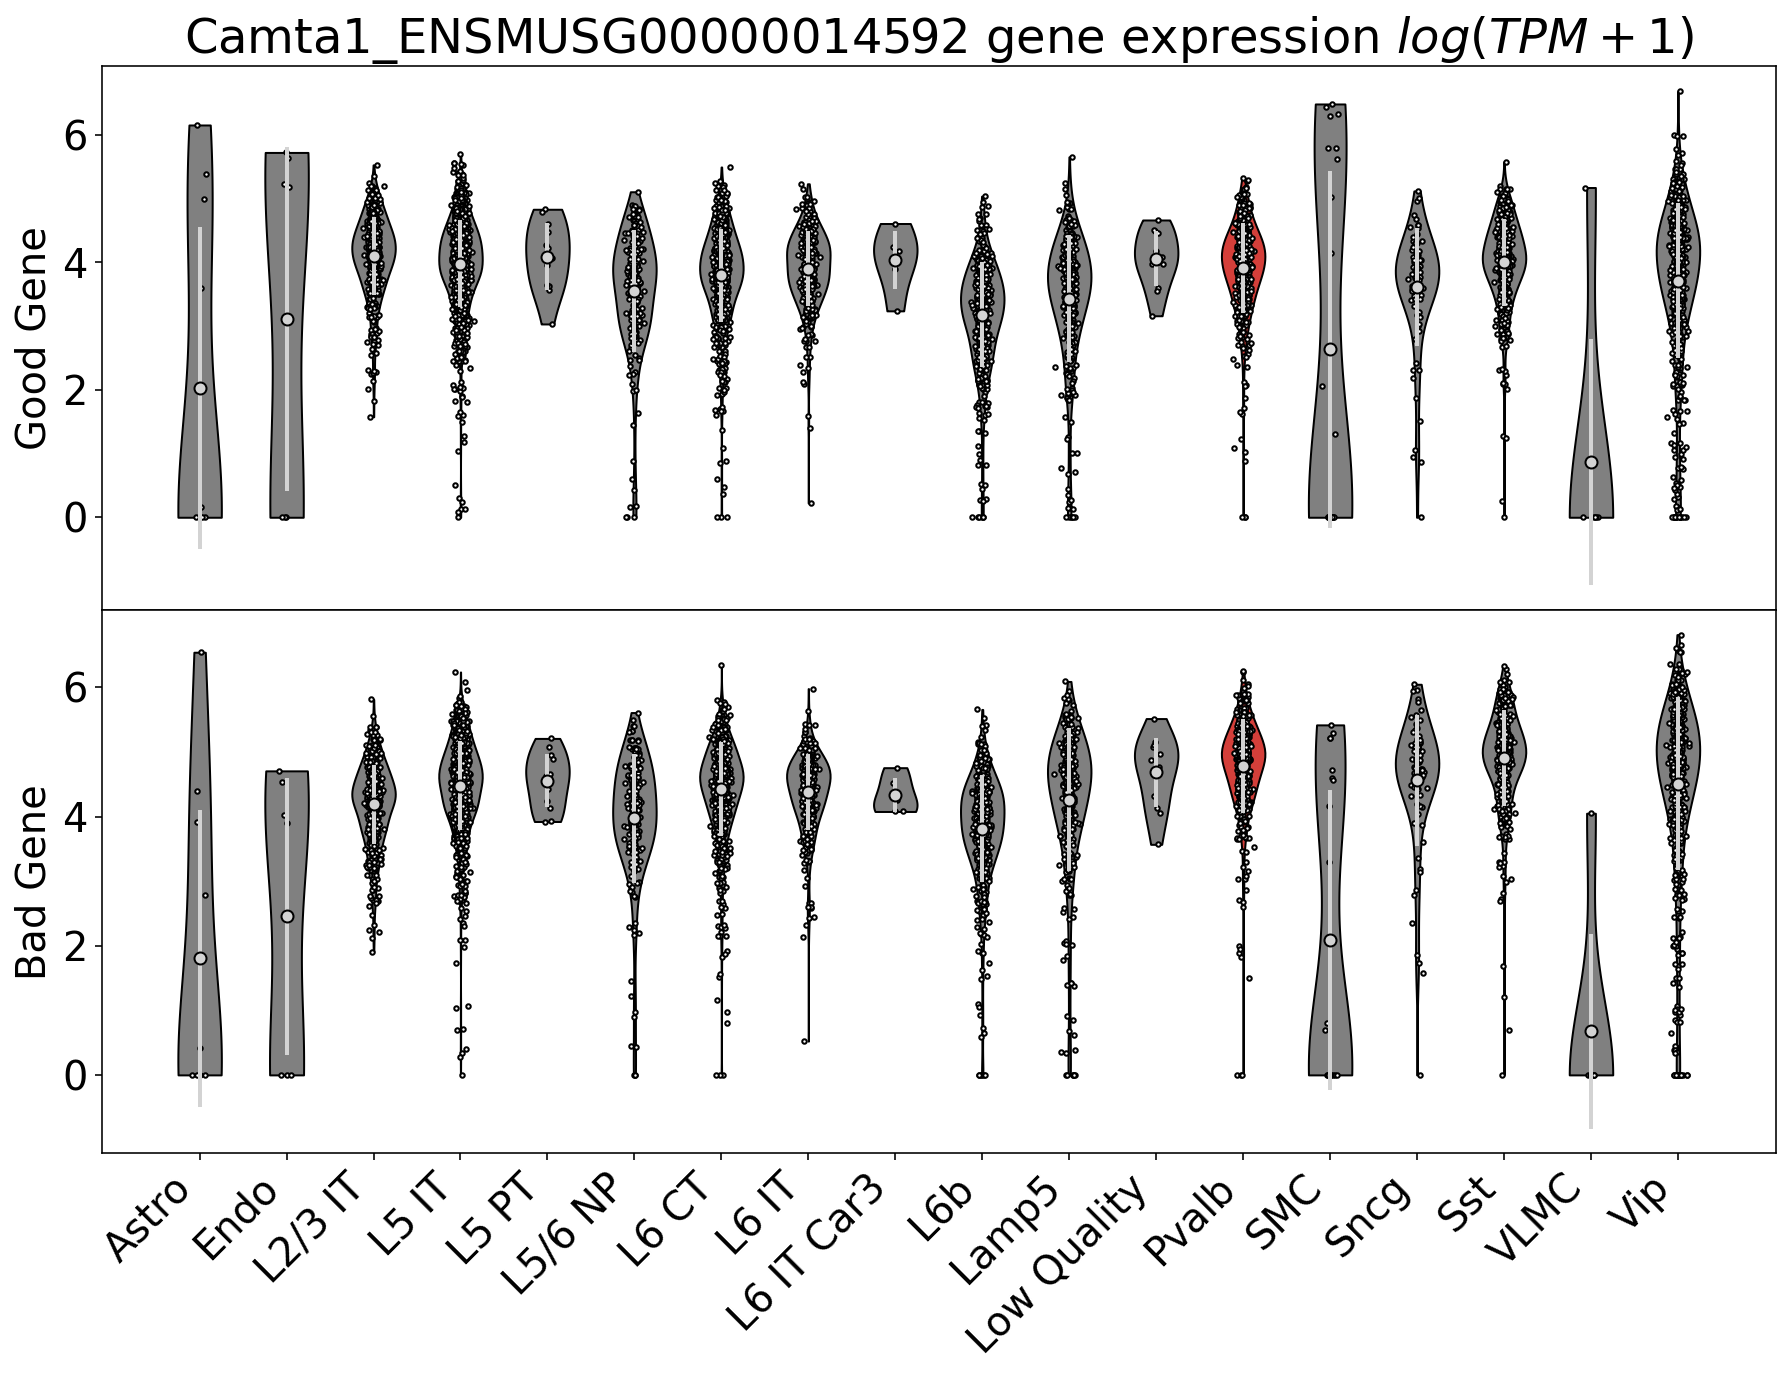

In [71]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2)
fig.subplots_adjust(hspace=0, wspace=0)

unique = np.unique(gene_good.obs.subclass_label.values)


labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]
#######3# Gene
x = []
for c in unique:
    x.append(np.asarray(gene_good[gene_good.obs.subclass_label==c][:,gene_good.var.gene_name.values==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[0], selected=midx)

#################### BAD GENE ####################
x = []
for c in unique:
    x.append(np.asarray(gene_bad[gene_bad.obs.subclass_label==c][:,gene_bad.var.gene_name.values==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[1], selected=midx, xticks=lidx, xticklabels=labels)


ax[0].set(**{
    "ylabel": "Good Gene",
    "title": "{} gene expression $log(TPM + 1)$".format(specific_gene)
})
ax[1].set(**{
    "ylabel": "Bad Gene",
})

#plt.savefig("./figures/class_DE_violin_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

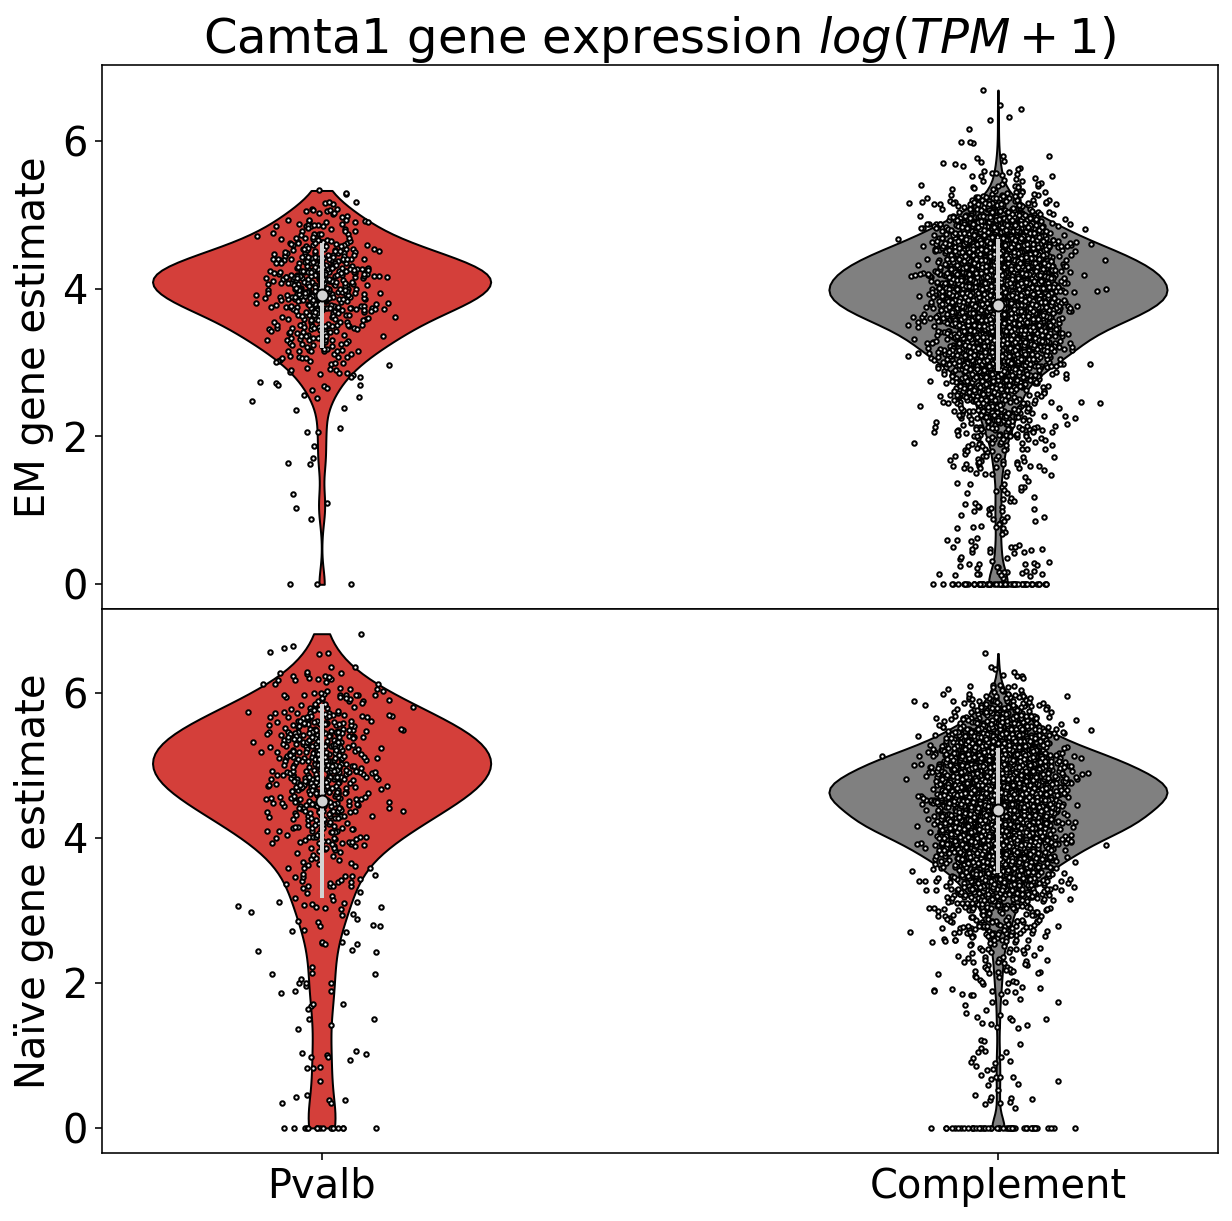

In [87]:
fig, ax = plt.subplots(figsize=(10,10), nrows=2)
fig.subplots_adjust(hspace=0, wspace=0)

unique = np.unique(gene_good.obs.subclass_label.values)


labels = [specific_cluster, "Complement"]
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]
#######3# Gene
x = []
x.append(np.asarray(gene_good[gene_good.obs.subclass_label==specific_cluster][:,gene_good.var.gene_name.values==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())
x.append(np.asarray(gene_good[gene_good.obs.subclass_label!=specific_cluster][:,gene_good.var.gene_name.values==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[0], selected=0)

#################### BAD GENE ####################
x = []

x.append(np.asarray(gene_bad[gene_bad.obs.subclass_label==c][:,gene_bad.var.gene_name.values==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())
x.append(np.asarray(gene_bad[gene_bad.obs.subclass_label!=c][:,gene_bad.var.gene_name.values==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[1], selected=0, xticks=lidx, xticklabels=labels)


ax[0].set(**{
    "ylabel": "EM gene estimate",
    "title": "{} gene expression $log(TPM + 1)$".format("".join(specific_gene.split("_")[:-1]))
})
ax[1].set(**{
    "ylabel": "Naïve gene estimate",
})

ax[1].set_xticklabels(labels, rotation=0, ha="center")


plt.savefig("../../figures/false_positive_violin_subclass_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

In [73]:
specific_cluster

'Pvalb'

In [74]:
mtx_good = nd(gene_good.layers["log1p"].todense()[:,gene_good.var.gene_name==specific_gene])
mtx_bad = nd(gene_bad.layers["log1p"].todense()[:,gene_bad.var.gene_name==specific_gene])

In [75]:
unique = np.unique(gene_good.obs.subclass_label)

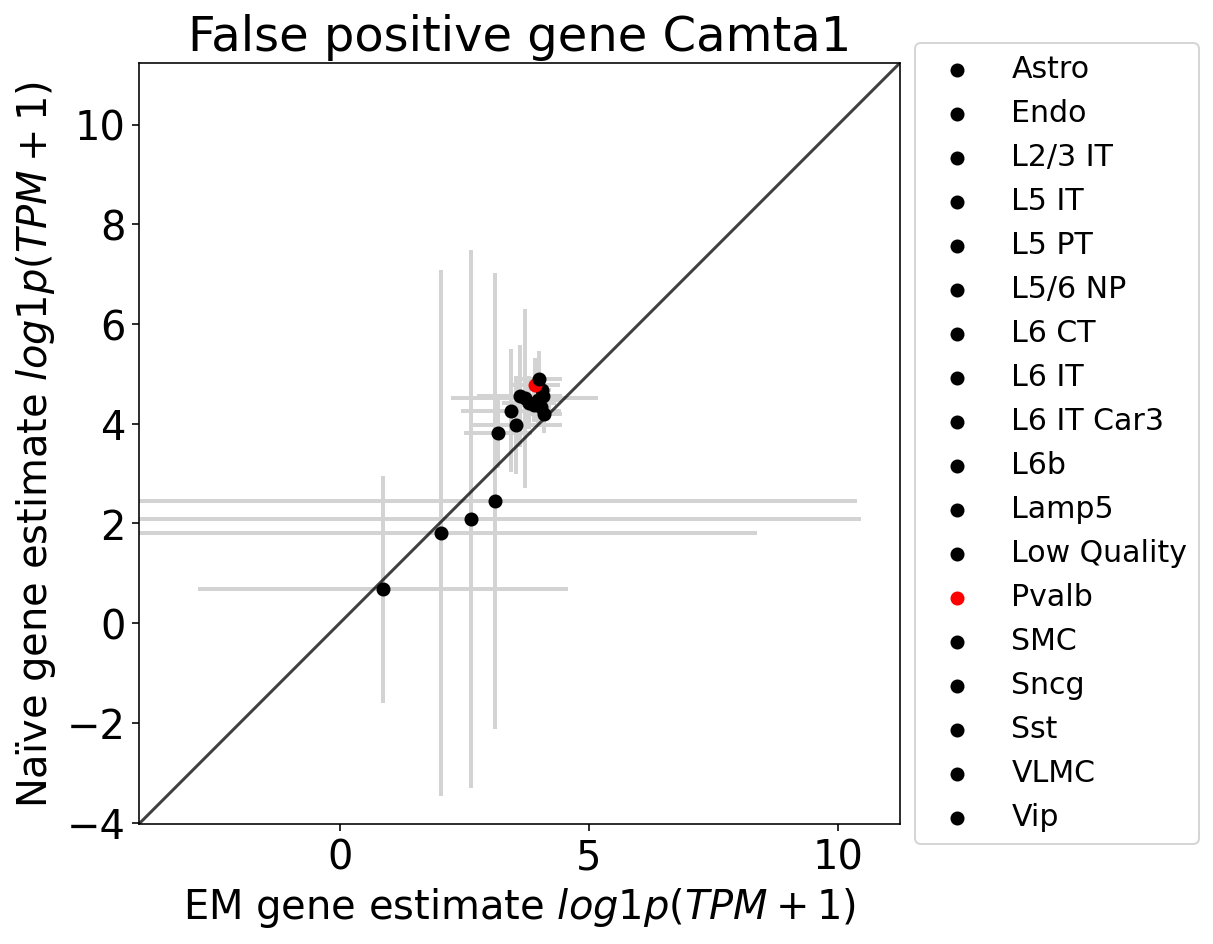

In [76]:
fig, ax = plt.subplots(figsize=(7,7))

ax.set_title("False positive gene {}".format(specific_gene.split("_")[0]))


x = []
y = []
xstdev = []
ystdev = []

for c in unique:
    x.append(mtx_good[gene_good.obs.subclass_label==c].mean(axis=0))
    xstdev.append(np.var(mtx_good[gene_good.obs.subclass_label==c], axis=0))

    y.append(mtx_bad[gene_bad.obs.subclass_label==c].mean(axis=0))
    ystdev.append(np.var(mtx_bad[gene_bad.obs.subclass_label==c], axis=0))

for cidx, c in enumerate(unique):
    color="black"
    if c == specific_cluster: color="red"
    xx = x[cidx]
    yy = y[cidx]
    xs = xstdev[cidx]
    ys = ystdev[cidx]
    ax.scatter(xx, yy, label="{}".format(c), color=color)
    ax.vlines(xx, yy - ys, yy+ys, color='lightgrey', linestyle='-', lw=2, zorder=-1)
    ax.hlines(yy, xx - xs, xx+xs, color='lightgrey', linestyle='-', lw=2, zorder=-1)
    
ax.set_xlim(0)
ax.set(**{
    "xlim": 0,
    "xlabel": "EM gene estimate $log1p(TPM +1)$",
    "ylabel": "Naïve gene estimate $log1p(TPM+1)$"
})
yex(ax)
ax.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5), fontsize=fsize-5)

#plt.savefig("../../figures/false_positive_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)

plt.show()


# False Negative

In [77]:
good.loc[fn].sort_values(["p_corr"]).head(10)

,index,name,p_raw,p_corr,es
Pvalb_Pclo_ENSMUSG00000061601,Pvalb,Pclo_ENSMUSG00000061601,1.049420e-35,3.731737e-32,-0.360935
L5 IT_Nptn_ENSMUSG00000032336,L5 IT,Nptn_ENSMUSG00000032336,4.069605e-33,2.309501e-29,0.151225
L6 CT_Zfp729a_ENSMUSG00000021510,L6 CT,Zfp729a_ENSMUSG00000021510,5.064686e-33,2.610339e-29,0.439296
L5 IT_Rab14_ENSMUSG00000026878,L5 IT,Rab14_ENSMUSG00000026878,5.070896e-32,2.877733e-28,-0.163708
L6 CT_C130073E24Rik_ENSMUSG00000110246,L6 CT,C130073E24Rik_ENSMUSG00000110246,4.833984e-28,2.491436e-24,-0.131928
Pvalb_Pafah1b1_ENSMUSG00000020745,Pvalb,Pafah1b1_ENSMUSG00000020745,8.439037e-28,3.000922e-24,0.366952
L5 IT_Kif1a_ENSMUSG00000014602,L5 IT,Kif1a_ENSMUSG00000014602,1.649478e-27,9.360785e-24,-0.226801
Pvalb_Eif1_ENSMUSG00000035530,Pvalb,Eif1_ENSMUSG00000035530,2.111464e-26,7.508367e-23,-0.111517
Pvalb_Zfp706_ENSMUSG00000062397,Pvalb,Zfp706_ENSMUSG00000062397,3.214942e-25,1.143233e-21,-0.208263
L2/3 IT_Pafah1b1_ENSMUSG00000020745,L2/3 IT,Pafah1b1_ENSMUSG00000020745,3.768075e-23,2.424756e-19,-0.259445


In [78]:
specific_cluster = "L6 CT" 
specific_gene = "Zfp729a_ENSMUSG00000021510"

In [79]:
specific_gene

'Zfp729a_ENSMUSG00000021510'

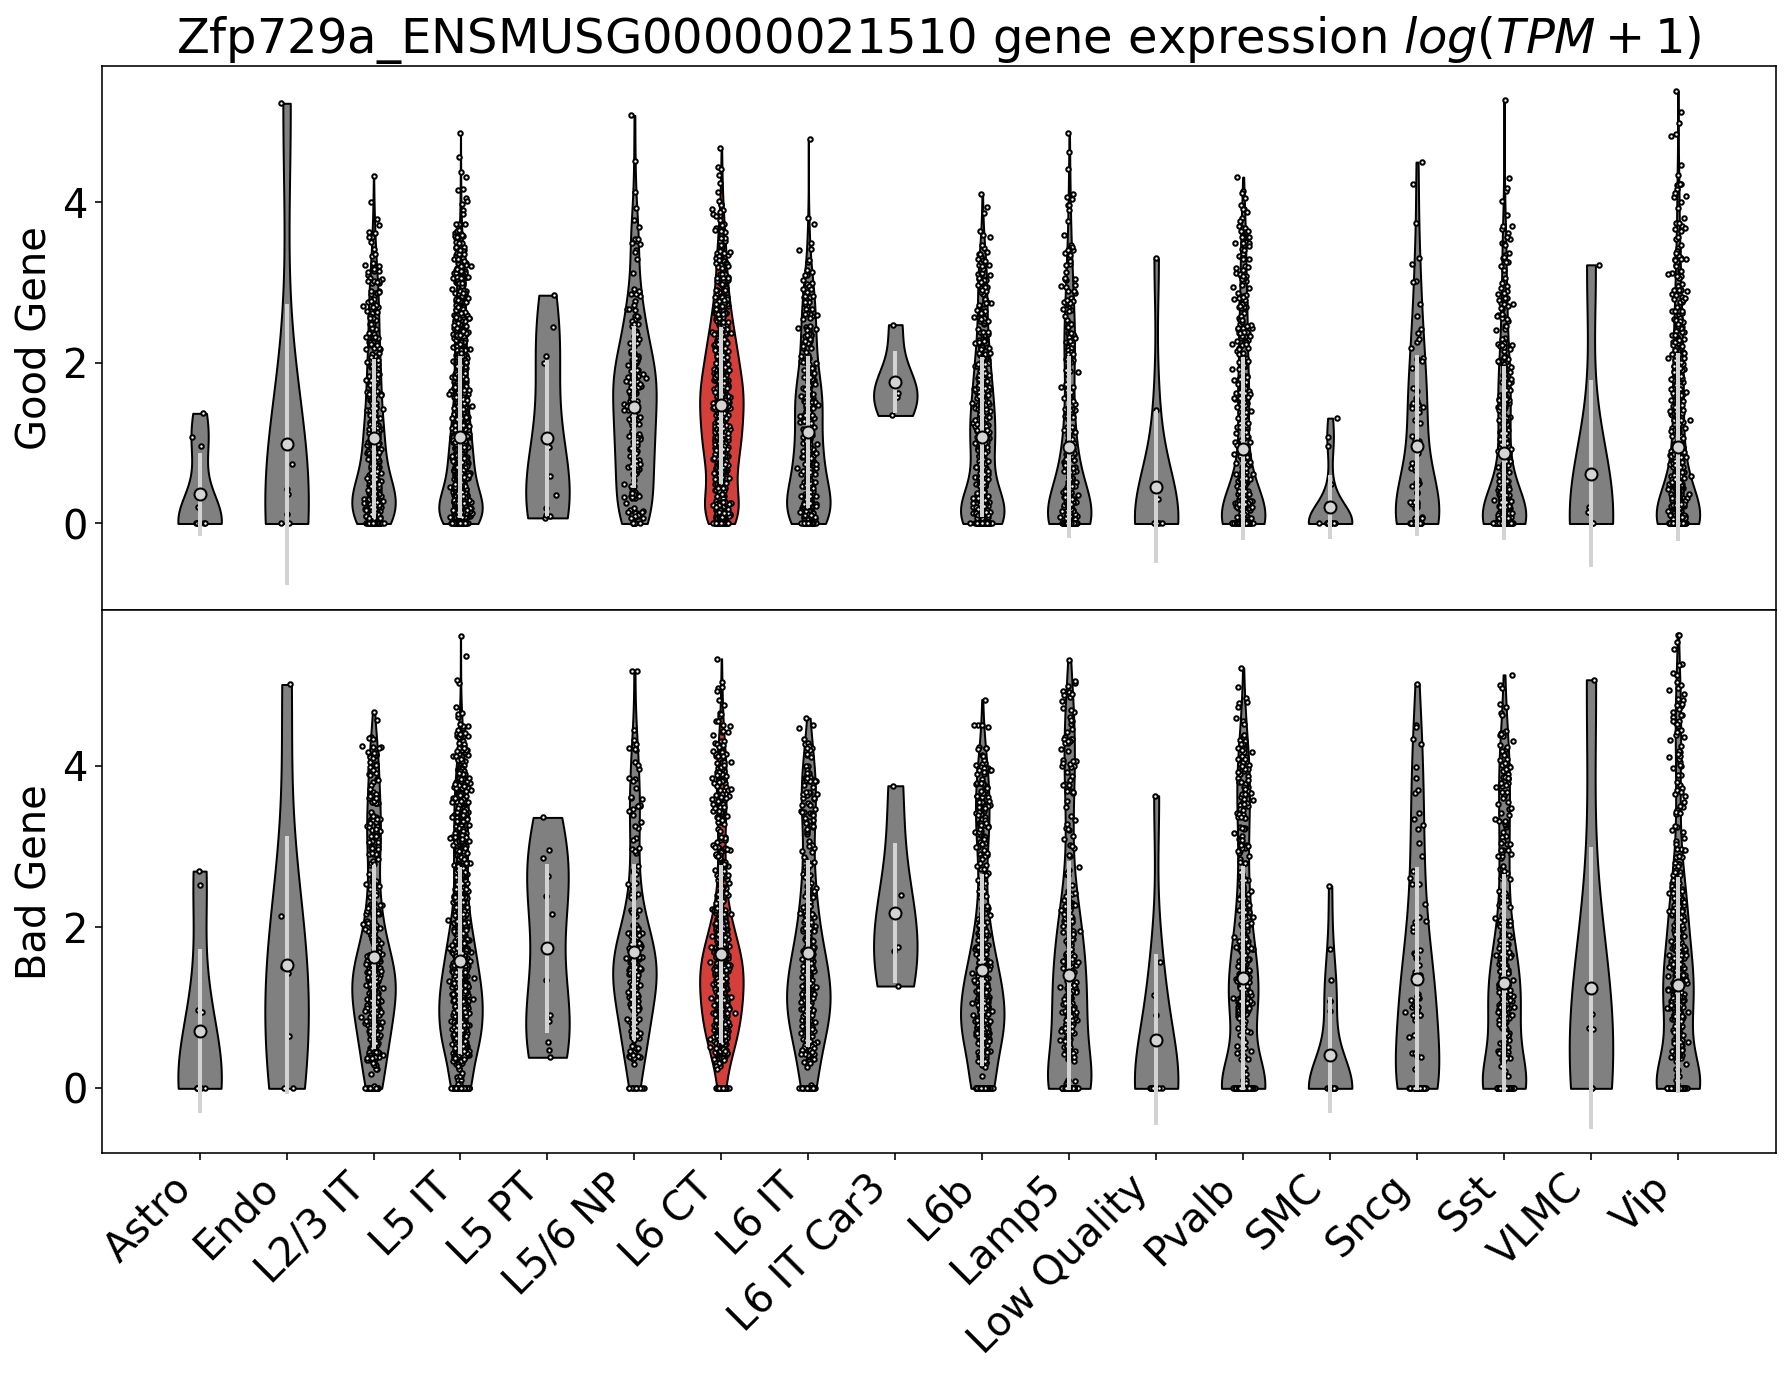

In [80]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2)
fig.subplots_adjust(hspace=0, wspace=0)

unique = np.unique(gene_good.obs.subclass_label.values)


labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]
#######3# Gene
x = []
for c in unique:
    x.append(np.asarray(gene_good[gene_good.obs.subclass_label==c][:,gene_good.var.gene_name.values==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())
y=x
violinplot(x, ax[0], selected=midx)

#################### BAD GENE ####################
x = []
for c in unique:
    x.append(np.asarray(gene_bad[gene_bad.obs.subclass_label==c][:,gene_bad.var.gene_name.values==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[1], selected=midx, xticks=lidx, xticklabels=labels)


ax[0].set(**{
    "ylabel": "Good Gene",
    "title": "{} gene expression $log(TPM + 1)$".format(specific_gene)
})
ax[1].set(**{
    "ylabel": "Bad Gene",
})

#plt.savefig("./figures/class_DE_violin_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

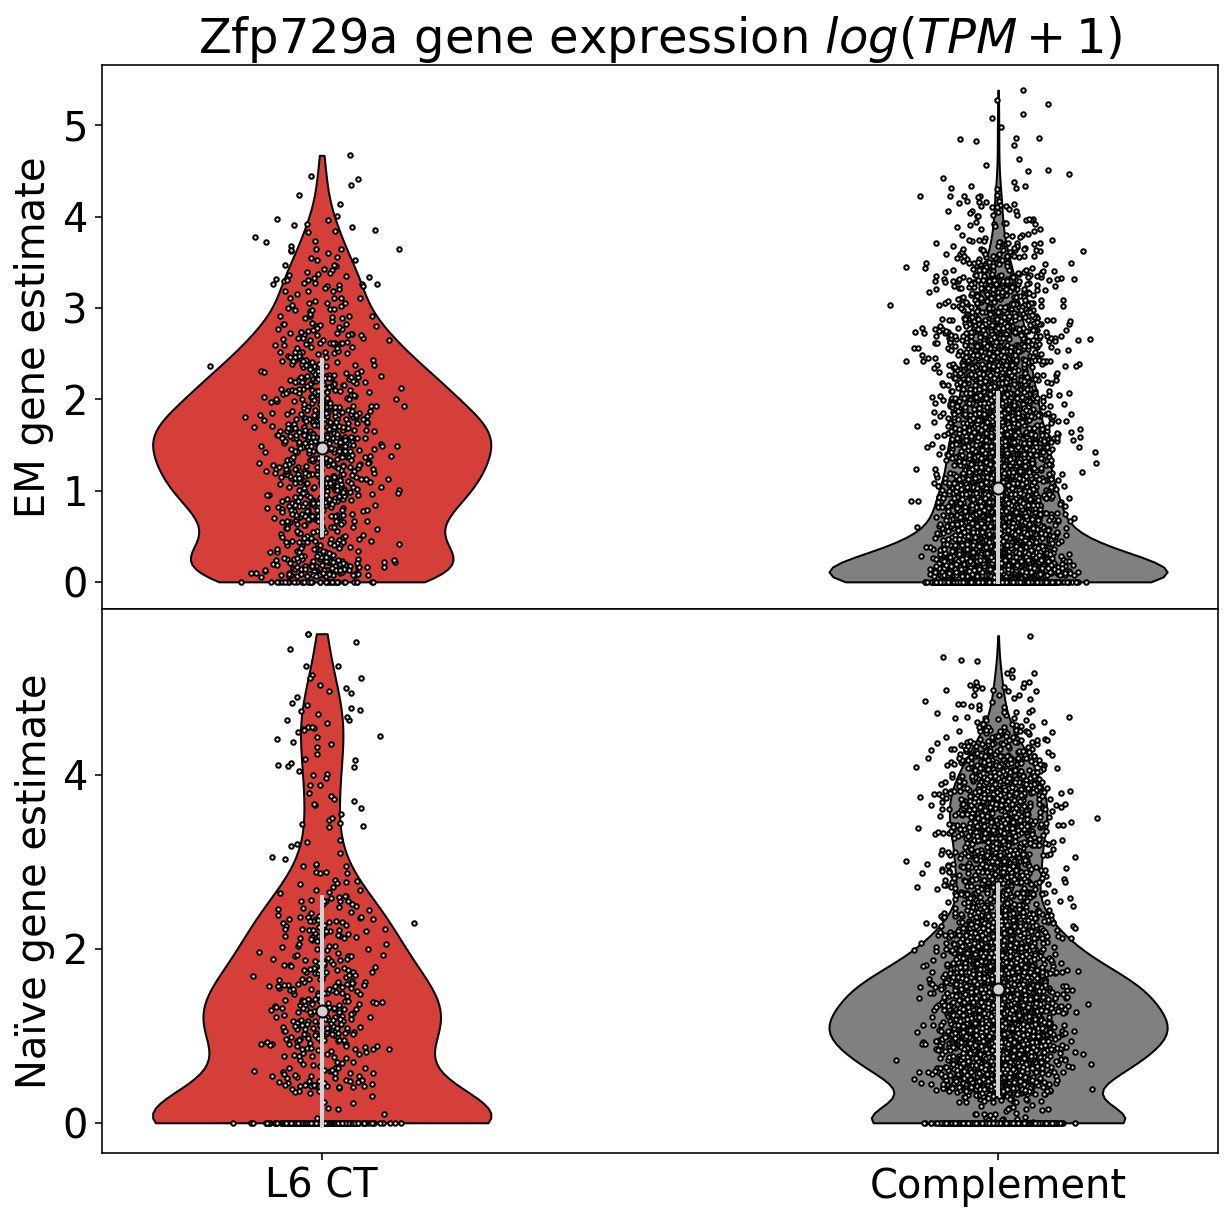

In [85]:
fig, ax = plt.subplots(figsize=(10,10), nrows=2)
fig.subplots_adjust(hspace=0, wspace=0)

unique = np.unique(gene_good.obs.subclass_label.values)


labels = [specific_cluster, "Complement"]
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]
#######3# Gene
x = []
x.append(np.asarray(gene_good[gene_good.obs.subclass_label==specific_cluster][:,gene_good.var.gene_name.values==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())
x.append(np.asarray(gene_good[gene_good.obs.subclass_label!=specific_cluster][:,gene_good.var.gene_name.values==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[0], selected=0)

#################### BAD GENE ####################
x = []

x.append(np.asarray(gene_bad[gene_bad.obs.subclass_label==c][:,gene_bad.var.gene_name.values==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())
x.append(np.asarray(gene_bad[gene_bad.obs.subclass_label!=c][:,gene_bad.var.gene_name.values==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[1], selected=0, xticks=lidx, xticklabels=labels)


ax[0].set(**{
    "ylabel": "EM gene estimate",
    "title": "{} gene expression $log(TPM + 1)$".format("".join(specific_gene.split("_")[:-1]))
})
ax[1].set(**{
    "ylabel": "Naïve gene estimate",
})

ax[1].set_xticklabels(labels, rotation=0, ha="center")


plt.savefig("../../figures/false_negative_violin_subclass_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

In [29]:

specific_cluster

'L6 CT'

In [30]:
mtx_good = nd(gene_good.layers["log1p"].todense()[:,gene_good.var.gene_name==specific_gene])
mtx_bad = nd(gene_bad.layers["log1p"].todense()[:,gene_bad.var.gene_name==specific_gene])

In [31]:
unique = np.unique(gene_good.obs.subclass_label)

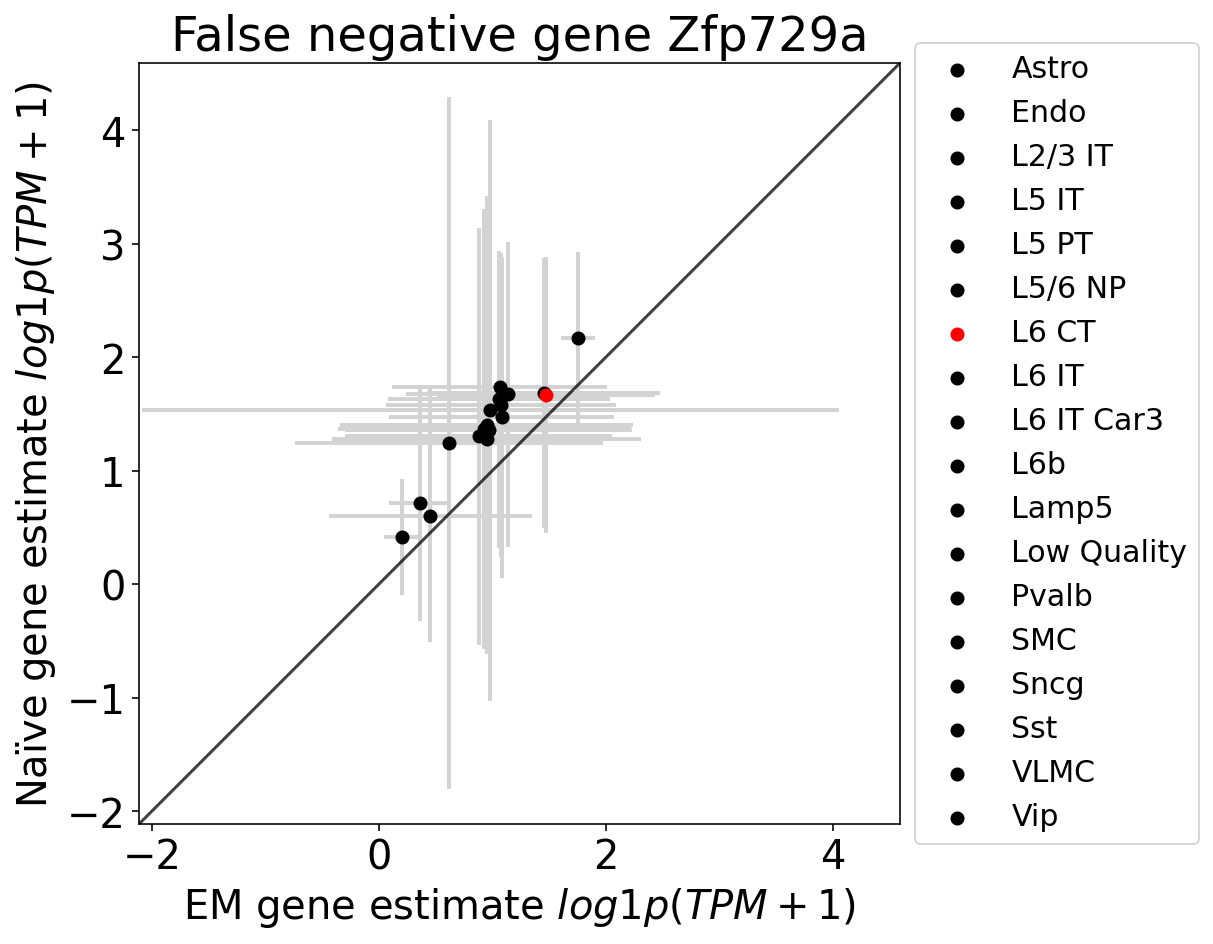

In [32]:
fig, ax = plt.subplots(figsize=(7,7))

ax.set_title("False negative gene {}".format(specific_gene.split("_")[0]))


x = []
y = []
xstdev = []
ystdev = []

for c in unique:
    x.append(mtx_good[gene_good.obs.subclass_label==c].mean(axis=0))
    xstdev.append(np.var(mtx_good[gene_good.obs.subclass_label==c], axis=0))

    y.append(mtx_bad[gene_bad.obs.subclass_label==c].mean(axis=0))
    ystdev.append(np.var(mtx_bad[gene_bad.obs.subclass_label==c], axis=0))

for cidx, c in enumerate(unique):
    color="black"
    if c == specific_cluster: color="red"
    xx = x[cidx]
    yy = y[cidx]
    xs = xstdev[cidx]
    ys = ystdev[cidx]
    ax.scatter(xx, yy, label="{}".format(c), color=color)
    ax.vlines(xx, yy - ys, yy+ys, color='lightgrey', linestyle='-', lw=2, zorder=-1)
    ax.hlines(yy, xx - xs, xx+xs, color='lightgrey', linestyle='-', lw=2, zorder=-1)

ax.set_xlim(0)
yex(ax)
ax.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5), fontsize=fsize-5)
ax.set_xlabel("EM gene estimate $log1p(TPM +1)$")
ax.set_ylabel("Naïve gene estimate $log1p(TPM+1)$")


#plt.savefig("../../figures/false_negative_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)


plt.show()


In [114]:
def f(x):
    T = 2471
    V = 860.58
    return ((V-x)*(x+5)-T*x)/(T+5+x)

In [119]:
f(100)

-64.92201086956521

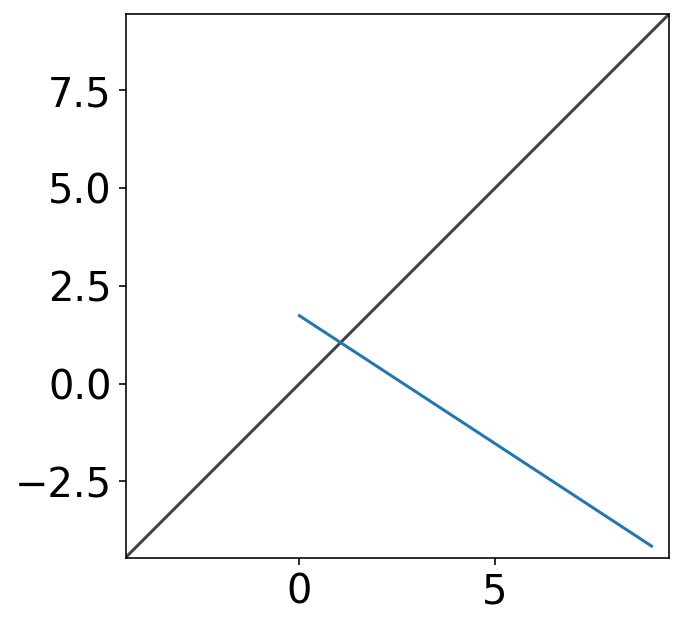

In [116]:
fig, ax = plt.subplots(figsize=(5,5))

y = [f(i) for i in range(0, 10)]
ax.plot(range(0, 10), y)
yex(ax)

In [113]:
f(200)

-149.31842301943198